# ㅇㅇ
- 코드 구현하는 단원만 진행

# 4. 트랜스포머의 입력 이해하기 - 입력 방식을 알아보고, PositionalEncoding Layer

In [10]:
!pip install sentencepiece

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        """
        Positional Encoding 클래스

        Args:
            position (int): 문장의 최대 길이 (max sequence length)
            d_model (int): 임베딩 벡터의 차원 (model dimension)
        """
        
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        # 위치별로 미리 계산된 사인/코사인 기반 위치 인코딩 행렬 생성
        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        """
        각 위치(pos)와 차원(i)에 대해 angle 값을 계산.

        Args:
            position (Tensor): [position, 1] 위치 인덱스
            i (Tensor): [1, d_model] 차원 인덱스
            d_model (int): 임베딩 차원

        Returns:
            Tensor: 위치-차원별 angle 값
        """
        # (2 * (i // 2)) : 짝수/홀수 차원 구분용
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

        # 사실 위처럼 지수계산보다는 log계산으로 푸는 것이 더 안정적이라 한다. 
        # angle_rates = torch.exp(- (2 * (i // 2)) * torch.log(torch.tensor(10000.0)) / d_model)
        # return position * angle_rates.unsqueeze(0)

    def _build_pos_encoding(self, position, d_model):
        """
        전체 위치 인코딩 행렬을 생성.

        Returns:
            pos_encoding: [1, position, d_model]
        """
        # 각 위치에 대해 0 ~ position-1까지의 인덱스 생성 → shape: [position, 1]
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        # 각 차원에 대해 0 ~ d_model-1까지의 인덱스 생성 → shape: [1, d_model]
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        # 각 위치와 차원에 대한 각도(angle) 계산
        angle_rads = self._get_angles(pos, i, d_model)

        # 짝수 인덱스(0, 2, 4, ...)에는 sin, 홀수 인덱스(1, 3, 5, ...)에는 cos 적용
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        # 최종 위치 인코딩 행렬 초기화
        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines  # 짝수 차원 → sin 값
        pos_encoding[:, 1::2] = cosines  # 홀수 차원 → cos 값

        # 배치 차원 추가: shape [1, position, d_model]
        pos_encoding = pos_encoding.unsqueeze(0)
        return pos_encoding

    def forward(self, x):
        """
        입력 임베딩(x)에 위치 인코딩을 더함.
        Args:
            x (Tensor): [batch_size, seq_len, d_model]
        Returns:
            Tensor: [batch_size, seq_len, d_model]
        """
        # 입력 길이(seq_len)에 맞는 부분만 잘라서 더함
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)


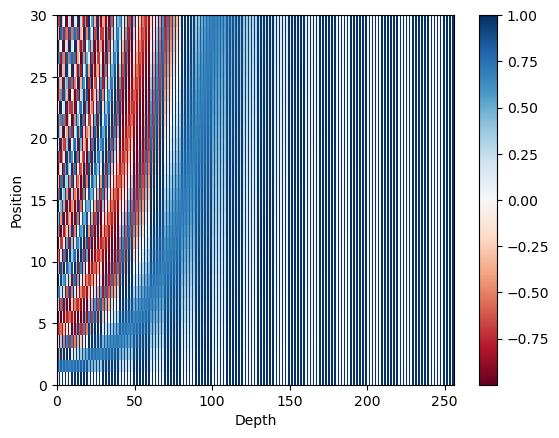

In [13]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 6. Scaled dot-product Attention

In [14]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Scaled Dot-Product Attention
    -------------------------------------------------------
    query: (batch_size, heads, seq_len_q, depth)
    key:   (batch_size, heads, seq_len_k, depth)
    value: (batch_size, heads, seq_len_v, depth)
    mask:  (optional) attention mask tensor
    return: (output, attention_weights)
    -------------------------------------------------------
    핵심 수식:
        Attention(Q, K, V) = softmax( (QK^T) / sqrt(d_k) ) * V
    """

    # 1) Query와 Key의 내적(dot-product)을 통해 유사도(score) 계산
    #    - key.transpose(-1, -2): 마지막 두 차원을 전치하여 (depth, seq_len_k)
    #    - 결과 shape: (batch_size, heads, seq_len_q, seq_len_k)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) Key 벡터의 차원(depth)에 따라 스케일링 (정규화)
    #    - 큰 값으로 인한 softmax gradient vanishing 방지
    #    - sqrt(depth)로 나눠줌
    depth = key.size(-1)
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크(mask)가 주어진 경우 적용
    #    - 패딩 토큰 또는 미래 토큰(Decoder의 causal mask) 무시용
    #    - 매우 작은 값(-1e9)을 더해 softmax에서 해당 위치의 확률을 0으로 만듦
    if mask is not None:
        logits = logits + (mask * -1e9)

    # 4) Softmax를 통해 attention weight 계산
    #    - 각 query에 대해 모든 key의 가중치 분포 생성
    #    - dim=-1: seq_len_k 차원(즉, key 차원)에 대해 정규화
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weight를 value에 곱해 weighted sum 계산
    #    - 결과: (batch_size, heads, seq_len_q, depth)
    output = torch.matmul(attention_weights, value)

    # output: context vector, attention_weights: 각 token 간 주의 분포
    return output, attention_weights


이외에도 Additive Attention (Bahdanau)와 Bilinear Attention(“General” Luong Attention)가 존재한다.

In [15]:
# ===========================================
# Bahdanau Attention with Mask
# ===========================================
class BahdanauAttention(nn.Module):
    def __init__(self, query_dim, key_dim, attn_dim):
        super().__init__()
        # Query와 Key를 동일한 차원(attn_dim)으로 변환하기 위한 가중치 행렬
        self.Wq = nn.Linear(query_dim, attn_dim)
        self.Wk = nn.Linear(key_dim, attn_dim)
        # tanh 출력(attn_dim)을 스칼라 값으로 바꾸는 벡터 v (유사도 점수용)
        self.v = nn.Linear(attn_dim, 1)

    def forward(self, query, keys, values, mask=None):
        """
        query : [batch_size, 1, query_dim] -> 디코더의 현재 hidden state 
        keys : [batch_size, seq_len, key_dim] -> 인코더의 hidden states 
        values: [batch_size, seq_len, value_dim] -> 실제 attention으로 가중합할 값 (보통 key와 동일)
        mask  : [batch_size, seq_len] (PAD 위치: 0, 실제 단어: 1)
        """
        # (1) Query, Key를 각각 attn_dim 차원으로 변환
        q_proj = self.Wq(query)
        k_proj = self.Wk(keys)

        # (2) 비선형 결합 (Additive 방식) # 각 Query와 Key의 조합에 대해 tanh(Wq*q + Wk*k) 
        # broadcasting에 의해 q_proj이 seq_len 차원으로 자동 확장됨
        score = self.v(torch.tanh(q_proj + k_proj)).squeeze(-1)  # [batch, seq_len]

        # 마스크 적용
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        # (3) softmax를 적용하여 attention weight 계산
        attn_weights = F.softmax(score, dim=-1).unsqueeze(-1)  # [batch, seq_len, 1]
        # (4) attention weight로 values의 가중합 (context vector)
        context = torch.sum(attn_weights * values, dim=1)       # [batch, value_dim]
        # (5) context: attention 결과 벡터, attn_weights: 가중치 분포
        return context, attn_weights

In [16]:
# ===========================================
# Bilinear (Luong General) Attention with Mask
# ===========================================
class BilinearAttention(nn.Module):
    def __init__(self, query_dim, key_dim):
        super().__init__()
        # Key를 Query 차원으로 선형 변환하는 가중치 행렬 W_a (bias 없음) 
        # 즉, W_a ∈ ℝ^(key_dim × query_dim)
        self.Wa = nn.Linear(key_dim, query_dim, bias=False)

    def forward(self, query, keys, values, mask=None):
        """
        query : [batch_size, query_len, query_dim]
        keys  : [batch_size, seq_len, key_dim]
        values: [batch_size, seq_len, value_dim]
        mask  : [batch_size, 1, seq_len] (PAD 위치: 0)
        """
        # (1) Key를 W_a로 변환하여 Query와 동일한 차원으로 맞춤
        keys_transformed = self.Wa(keys)
        # (2) Query와 변환된 Key의 쌍선형 내적 계산 (qᵀW_a k) 
        # -> (batch, query_len, seq_len)
        score = torch.matmul(query, keys_transformed.transpose(-1, -2))  # [batch, query_len, seq_len]

        # 마스크 적용
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        # (3) softmax로 attention weight 계산 (각 query에 대한 key 중요도)
        attn_weights = F.softmax(score, dim=-1)
        # (4) attention weight를 이용해 values의 가중합(context vector) 계산 
        # -> (batch, query_len, value_dim)
        context = torch.matmul(attn_weights, values)
        # (5) context: attention 출력, attn_weights: attention 분포
        return context, attn_weights

# 7. Multi-Head Attention

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 병렬적으로 나눠 계산할 헤드(head)의 개수
        self.d_model = d_model      # 입력/출력의 전체 차원 (embedding dimension)

        # d_model은 num_heads로 정확히 나누어떨어져야 함
        # (예: d_model=512, num_heads=8 → head당 depth=64)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # 각 head에서 사용할 벡터의 차원
        self.depth = d_model // num_heads

        # Q, K, V를 생성하기 위한 선형 변환 (각각 d_model → d_model)
        # 학습 가능한 가중치 행렬을 통해 입력을 head 차원으로 투영
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        # 모든 head를 다시 결합한 후, 최종 출력 차원 복원용 선형 변환
        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        입력 x를 num_heads 개로 분리하는 함수
        ---------------------------------------------------
        x: (batch_size, seq_len, d_model)
        반환: (batch_size, num_heads, seq_len, depth)
        ---------------------------------------------------
        - d_model을 num_heads로 나누어 각 head가 처리할 부분 벡터로 분할
        - 이후 permute를 통해 head 차원을 앞으로 이동
        """
        # (batch_size, seq_len, d_model) → (batch_size, seq_len, num_heads, depth)
        x = x.view(batch_size, -1, self.num_heads, self.depth)

        # (batch_size, num_heads, seq_len, depth) 형태로 차원 재배치
        x = x.permute(0, 2, 1, 3)
        return x

    def forward(self, query, key, value, mask=None):
        """
        Multi-Head Attention의 순전파(forward) 과정
        ---------------------------------------------------
        query, key, value: (batch_size, seq_len, d_model)
        mask: (optional) Attention mask
        ---------------------------------------------------
        출력: (batch_size, seq_len, d_model)
        """
        batch_size = query.size(0)

        # 1) 입력 벡터에 각각 Linear layer 적용 → Q, K, V 생성
        #    shape: (batch_size, seq_len, d_model)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2) Head별로 분리 (num_heads, depth 구조로 변환)
        #    shape: (batch_size, num_heads, seq_len, depth)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3) 각 head별로 Scaled Dot-Product Attention 수행
        #    반환값: (batch_size, num_heads, seq_len, depth)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # 4) 모든 head의 결과를 다시 결합하기 위해 차원 순서 재정렬
        #    (batch_size, num_heads, seq_len, depth)
        #      → (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 5) num_heads와 depth를 결합해 원래 d_model 차원으로 복원
        #    shape: (batch_size, seq_len, d_model)
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 6) 최종 선형 변환을 통해 head 통합 결과를 출력 차원으로 투영
        #    (batch_size, seq_len, d_model)
        output = self.out_dense(concat_attention)

        return output

# 8. Masking - Padding Masking, Look ahead Masking

## 8-1. Padding Masking

In [18]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


## 8-2. Look ahead Masking

In [19]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # 1) Look-ahead 마스크 생성
    # torch.ones((seq_len, seq_len)) → 1로 채워진 정방행렬 생성
    # torch.tril() → 하삼각(자기 자신 포함) 부분만 남기고 나머지를 0으로 만듦
    # 1 - tril(...) → 상삼각(즉, 미래 토큰 위치)이 1, 나머지는 0
    # => Decoder가 아직 보지 않은 미래 단어를 참고하지 않도록 차단
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 2) 입력 x에서 패딩 위치(0인 부분)를 찾아 패딩 마스크 생성
    # shape: (batch_size, 1, 1, seq_len)
    padding_mask = create_padding_mask(x)

    # 3) Look-ahead 마스크 차원 확장
    # (seq_len, seq_len) → (1, seq_len, seq_len) → (1, 1, seq_len, seq_len)
    # => Attention 연산 시 브로드캐스팅이 가능하도록 형태 맞춤
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # 4) Look-ahead 마스크와 패딩 마스크를 결합
    # torch.max()를 사용하여 둘 중 하나라도 1인 위치는 모두 마스킹 처리
    # 최종 shape: (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    
    return combined_mask


In [20]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape, '\n')

x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5]) 

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


# 9. Encoder

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()

        # (1) 멀티-헤드 어텐션 (Self-Attention)
        # 입력 문장 내 단어들이 서로 어떤 관계를 맺고 있는지 학습
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)  # 잔차 연결 후 정규화

        # (2) 포지션별 피드포워드 네트워크 (Feed Forward Network)
        # 각 위치의 특징을 비선형 변환을 통해 확장
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # 차원 확장
            nn.ReLU(),                   # 비선형 활성화
            nn.Linear(ff_dim, d_model)   # 원래 차원으로 복귀
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)  # 두 번째 정규화

    def forward(self, x, mask=None):
        """
        Args:
            x: 입력 텐서 (batch_size, seq_len, d_model)
            mask: 패딩 마스크 (선택적)

        Returns:
            out2: 인코더 레이어의 출력 (batch_size, seq_len, d_model)
        """

        # (1) 멀티-헤드 셀프 어텐션
        # Query, Key, Value 모두 같은 입력 x를 사용
        attn_output = self.mha(x, x, x, mask)         # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)      # 드롭아웃으로 과적합 방지
        out1 = self.norm1(x + attn_output)            # 잔차 연결(residual) + LayerNorm

        # (2) 포지션별 피드포워드 신경망
        ffn_output = self.ffn(out1)                   # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)        # 드롭아웃 적용
        out2 = self.norm2(out1 + ffn_output)          # 잔차 연결 + LayerNorm

        return out2


In [22]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 단어 임베딩 (Word Embedding)
        # 입력 토큰 ID를 고정 크기 벡터(d_model 차원)로 변환
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 위치 임베딩 (Positional Encoding)
        # 문장 내 단어 순서(위치) 정보를 추가해 순서 의존성 학습 가능하게 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        # 드롭아웃: 학습 시 일부 뉴런 비활성화로 과적합 방지
        self.dropout = nn.Dropout(dropout)

        # (3) 인코더 블록(EncoderLayer)들을 num_layers 개만큼 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        """
        Args:
            x: 입력 토큰 시퀀스 (batch_size, seq_len)
            mask: 패딩 마스크 (선택적)

        Returns:
            x: 인코더의 출력 벡터 (batch_size, seq_len, d_model)
        """

        # (1) 단어 임베딩 + 스케일링
        # sqrt(d_model)로 스케일링해 학습 안정화 (Attention 계산 시 값이 너무 작아지는 것 방지)
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 추가 + 드롭아웃
        # 위치 정보가 추가된 임베딩이 self-attention으로 입력됨
        x = self.pos_encoding(x)                     # (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) N개의 EncoderLayer를 순차적으로 통과
        # 각 레이어에서 self-attention → feed-forward → 정규화 과정을 거침
        for layer in self.enc_layers:
            x = layer(x, mask)

        # (4) 최종 인코더 출력
        return x


# 10. Decoder

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # (1) 디코더 내부의 셀프 어텐션 (Masked Multi-Head Attention)
        # => 이전 시점까지만 참조하도록 Look-ahead Mask 사용
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # (2) 인코더-디코더 어텐션
        # => 디코더가 인코더의 출력(컨텍스트)을 참고하도록 하는 Cross-Attention
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # (3) 포지션별 피드포워드 네트워크 (Position-wise Feed Forward Network)
        # => 각 위치의 피처를 독립적으로 비선형 변환
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # 확장
            nn.ReLU(),                   # 비선형 활성화
            nn.Linear(ff_dim, d_model)   # 축소 (원래 차원 복원)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃: 각 서브 레이어의 출력에 적용
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        """
        Args:
            x: 디코더 입력 (batch_size, target_seq_len, d_model)
            enc_outputs: 인코더 출력 (batch_size, input_seq_len, d_model)
            look_ahead_mask: 미래 단어를 가리는 마스크
            padding_mask: 인코더 출력에서 패딩 위치를 가리는 마스크

        Returns:
            out3: 디코더 레이어의 출력 (batch_size, target_seq_len, d_model)
        """

        # (1) Masked Self-Attention
        # => 디코더가 다음 단어를 미리 보지 않도록 Look-ahead Mask 사용
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # (2) Encoder-Decoder Attention (Cross-Attention)
        # => 인코더 출력(enc_outputs)을 Key, Value로 사용해 입력 문맥 정보 활용
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # (3) Position-wise Feed Forward Network
        # => 각 시점별로 독립적인 비선형 변환 수행
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3


In [24]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 토큰 임베딩 레이어
        # 입력된 토큰 인덱스(정수 시퀀스)를 d_model 차원의 임베딩 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩 (Positional Encoding)
        # 디코더 입력 시퀀스의 위치 정보를 벡터에 더해줌
        # ※ 실제 구현에서는 vocab_size 대신 max_seq_len을 사용하는 경우가 많음
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        # (3) 드롭아웃
        self.dropout = nn.Dropout(dropout)

        # (4) DecoderLayer를 num_layers만큼 스택
        # 각 레이어는 (Self-Attention → Encoder-Decoder Attention → FFN) 순서로 구성
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        """
        Args:
            x: 디코더 입력 (batch_size, target_seq_len)
            enc_outputs: 인코더 출력 (batch_size, input_seq_len, d_model)
            look_ahead_mask: 미래 단어 마스크 (디코더 셀프 어텐션용)
            padding_mask: 인코더 출력의 패딩 위치 마스크 (Cross-Attention용)
        Returns:
            x: 디코더 출력 (batch_size, target_seq_len, d_model)
        """

        # (1) 임베딩 + 스케일링
        # 임베딩 결과를 √d_model로 스케일링해 학습 안정화
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 추가 + 드롭아웃
        # 위치 정보(positional encoding)를 더해 순서 정보 보존
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) 여러 개의 DecoderLayer를 순차적으로 통과
        # 각 layer는 Masked Self-Attention → Cross-Attention → FFN 구조
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        # (4) 디코더의 최종 출력 반환
        # 각 타임스텝별로 문맥이 반영된 벡터 (d_model 차원)
        return x

# 11. 챗봇의 병렬 데이터 받아오기

In [25]:
# 코넬 대사 데이터셋 다운로드 URL
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'
zip_filename = 'data/Node4/cornell_movie_dialogs.zip'

# 이미 파일이 없는 경우에만 다운로드
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename} ...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")

extract_dir = os.path.join("data/Node4")
os.makedirs(extract_dir, exist_ok=True)

# ZIP 파일 압축 해제
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)  # 압축을 data/Node4/ 안에 풀기

# ZIP 파일 삭제
!rm -rf data/Node4/cornell_movie_dialogs.zip

# 코넬 대사 데이터 폴더 경로
path_to_dataset = os.path.join(extract_dir, "cornell movie-dialogs corpus")

# 개별 파일 경로 설정
path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

print("path_to_dataset:", path_to_dataset)
print("path_to_movie_lines:", path_to_movie_lines)
print("path_to_movie_conversations:", path_to_movie_conversations)

Download complete.
path_to_dataset: data/Node4/cornell movie-dialogs corpus
path_to_movie_lines: data/Node4/cornell movie-dialogs corpus/movie_lines.txt
path_to_movie_conversations: data/Node4/cornell movie-dialogs corpus/movie_conversations.txt


In [26]:
def preprocess_sentence(sentence):
    """
    문장 전처리 함수
    - 입력 문장을 소문자로 변환하고, 불필요한 공백 및 특수문자를 정리합니다.
    - 구두점(punctuation) 앞뒤에 공백을 추가하여 토큰화를 용이하게 합니다.

    Args:
        sentence (str): 원본 문장

    Returns:
        str: 전처리된 문장
    """
    
    sentence = sentence.lower().strip() # 1. 소문자로 변환 및 양쪽 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 2. 구두점 앞뒤에 공백 추가 (예: "student." → "student .")
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 다중 공백을 단일 공백으로 축소
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence) # 4. 알파벳(a-z, A-Z) 및 구두점(?.!,)을 제외한 모든 문자 제거
    sentence = sentence.strip() # 5. 앞뒤 공백 제거 후 반환

    return sentence

In [27]:
def read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=50000):
    """
    코넬 영화 대사 데이터셋을 읽어 (질문, 답변) 쌍으로 구성하는 함수.

    Args:
        path_to_movie_lines (str): movie_lines.txt 파일 경로
        path_to_movie_conversations (str): movie_conversations.txt 파일 경로
        max_samples (int, optional): 최대 추출할 (질문, 답변) 쌍 수. 기본값은 50,000

    Returns:
        list[tuple[str, str]]: (질문, 답변) 쌍의 리스트
    """

    # (1) 각 대사(line_id → 대사 내용) 매핑 딕셔너리 생성
    id2line = {}
    with open(path_to_movie_lines, 'r', errors='ignore') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) >= 5:
            line_id = parts[0]      # 예: "L194"
            text = parts[4]         # 실제 대사 내용
            id2line[line_id] = text

    # (2) 대화(conversation) 파일을 읽어 (질문, 답변) 쌍 생성
    pairs = []
    with open(path_to_movie_conversations, 'r', errors='ignore') as f:
        conv_lines = f.readlines()

    for line in conv_lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) < 4:
            continue

        # (3) 대화 ID 리스트 추출 → ["L1045", "L1044", "L1043", ...]
        conv_str = parts[3]
        conv_list = conv_str[1:-1].split(", ")
        conv_list = [c.strip("'") for c in conv_list]  # "'L1045'" → "L1045"

        # (4) 연속된 두 문장을 (질문, 답변) 쌍으로 구성
        for i in range(len(conv_list) - 1):
            q_id = conv_list[i]
            a_id = conv_list[i + 1]
            q_text = id2line.get(q_id, "")
            a_text = id2line.get(a_id, "")

            # (5) 문장 전처리 (소문자 변환, 특수문자 정리 등)
            q_text = preprocess_sentence(q_text)
            a_text = preprocess_sentence(a_text)

            pairs.append((q_text, a_text))

            # (6) 최대 샘플 개수 도달 시 종료
            if len(pairs) >= max_samples:
                return pairs

    return pairs


In [28]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000

pairs = read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=MAX_SAMPLES)

print('전체 샘플 수 :', len(pairs))

전체 샘플 수 : 50000


# 12. 병렬 데이터 전처리하기 - 전처리과정을 수행 및 교사 강요에 대해서 학습

## 12-1 Tokenizer 학습

In [29]:
corpus_file = extract_dir+"clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [30]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,                     # 학습할 말뭉치 파일 경로 (한 줄에 한 문장)
    model_prefix=extract_dir+"spm_cornell",# 생성될 모델 파일 이름 접두사
    vocab_size=8000,                       # 단어 집합 크기 (토큰 개수)
    character_coverage=1.0,                # 말뭉치 내 모든 문자를 학습에 포함 (1.0 = 전체)
    model_type="bpe",                       # 모델 유형: 'bpe', 'unigram', 'char', 'word'
    max_sentence_length=999999,            # 한 문장 최대 길이 제한 (길게 잡음)
    bos_id=1,                              # 문장 시작 토큰 <s> ID
    eos_id=2,                              # 문장 종료 토큰 </s> ID
    pad_id=0,                              # 패딩 토큰 ID
    unk_id=3                               # 알 수 없는 단어(UNK) 토큰 ID
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/Node4clean_corpus.txt
  input_format: 
  model_prefix: data/Node4spm_cornell
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential

In [31]:
sp = spm.SentencePieceProcessor()
sp.Load(extract_dir+"spm_cornell.model")

True

In [32]:
# 예제 문장
sentence = "I'm learning PyTorch with SentencePiece!"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: i m learning pytorch with sentencepiece !
Tokenized: ['▁i', '▁m', '▁learning', '▁p', 'y', 't', 'or', 'ch', '▁with', '▁sent', 'ence', 'p', 'iece', '▁!']
Encoded: [6, 13, 4954, 37, 7983, 7971, 36, 119, 113, 1412, 651, 7991, 4122, 69]
Decoded: i m learning pytorch with sentencepiece !


## 12-2 Dataset 구현

In [33]:
class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 질문과 답변 문장을 SentencePiece로 토크나이즈 (ID 시퀀스로 변환)
            # sp.EncodeAsIds() 사용: 문장을 토큰 ID 리스트로 변환
            # 예: "hello world" -> [12, 345]
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) BOS(<s>)와 EOS(</s>) 토큰 추가
            # sp.bos_id(), sp.eos_id()로 문장의 시작과 끝 표시
            # 학습 시 모델이 문장 시작과 끝을 알 수 있도록 함
            # 만약 BOS/EOS ID가 정의되지 않았으면 임의값 사용
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 최대 길이(max_length) 초과 시 제외
            # 너무 긴 문장은 학습에서 제외
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 패딩: 최대 길이에 맞게 0(<pad>)으로 채움
            # sp.piece_to_id('<pad>')를 이용하면 모델에서 정의된 pad ID를 활용 가능
            q_tokens += [0] * (max_length - len(q_tokens))
            a_tokens += [0] * (max_length - len(a_tokens))

            # 5) 디코더 입력과 타겟 생성 (Teacher Forcing 적용)
            # 디코더 입력(dec_input)은 [BOS, 토큰1, ...] (마지막 토큰 제외)
            # 타겟(target)은 [토큰1, 토큰2, ..., EOS] (첫 번째 토큰 제외)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            # 6) 데이터셋에 샘플 저장
            self.data.append({
                "enc_input": q_tokens,  # Encoder 입력
                "dec_input": dec_input,  # Decoder 입력 (Teacher Forcing)
                "target": target         # Decoder 출력(타겟)
            })

    def __len__(self):
        # 전체 샘플 수 반환
        return len(self.data)

    def __getitem__(self, idx):
        # idx 번째 샘플 반환
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target


In [34]:
dataset = CornellDataset(pairs, sp, max_length=40)

In [35]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1,  115,   52,  321,   99, 1609,   23,  304, 7997, 7734,   62,   36,
        7978,  271,   61,   61,  891, 6222,  121, 1060,   39, 3631, 7741, 1337,
          15,  141,  280, 1882,  919,  161,   72,   19,  333,  103,    5,  463,
           5,    2,    0,    0])
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
tensor([   1,  189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182,
        5984,   17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
well , i thought we d start with pronunciation , if that s okay with you .
tensor([ 189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182, 5984,
          17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0

## 12-3 DataLoader 구성하기

In [36]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [37]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


# 13. 모델 정의 및 학습하기

In [38]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # Feed-Forward Network의 은닉 차원 (ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 1) 인코더 초기화
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 2) 디코더 초기화
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 3) 최종 출력층: d_model -> vocab_size
        # 디코더 출력 벡터를 단어 확률로 변환
        self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, dec_inputs):
        """
        inputs: 인코더 입력 (batch_size, src_seq_len)
        dec_inputs: 디코더 입력 (batch_size, tgt_seq_len)
        """
        # 1) 인코더 패딩 마스크 생성
        # PAD 토큰 위치는 1, 실제 토큰은 0
        enc_padding_mask = create_padding_mask(inputs)     # shape: (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 Look-Ahead Mask + 패딩 마스크
        # 디코더에서 미래 토큰을 보지 않도록 상삼각 마스크 적용
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 사용
        # 인코더 입력의 PAD 토큰 위치를 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape: (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # 디코더 입력 (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# 인코더 출력 (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Linear 레이어: d_model -> vocab_size
        # 각 위치마다 단어 확률(logits) 출력
        logits = self.final_linear(dec_outputs)  # shape: (batch_size, tgt_seq_len, vocab_size)

        return logits


In [39]:
# 예시: 하이퍼파라미터 설정
NUM_LAYERS = 2      # 인코더/디코더 층 수
D_MODEL = 256       # 임베딩 및 내부 표현 차원
NUM_HEADS = 8       # 멀티헤드 어텐션 헤드 수
UNITS = 512         # Feed-Forward Network 은닉 차원 (ff_dim)
DROPOUT = 0.1       # 드롭아웃 비율
VOCAB_SIZE = 8000   # 단어 집합 크기 (예시)

model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [40]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [41]:
def get_lr_lambda(d_model, warmup_steps=4000):
    """
    Transformer 학습 시 사용되는 학습률 스케줄 함수(Step-wise learning rate scheduler) 생성.

    d_model: 모델 내부 표현 차원 (embedding 차원)
    warmup_steps: 학습률 warm-up 단계 수

    반환값: 현재 step에 따른 학습률 비율 계산 함수
    """
    d_model = float(d_model)

    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1

        # 수식: d_model^-0.5 * min(step^-0.5, step * warmup_steps^-1.5)
        # - 초기 단계(warmup)에서는 step * warmup_steps^-1.5가 작아 학습률 점점 증가
        # - warmup 이후에는 step^-0.5가 작아져 학습률 점점 감소
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

    return lr_lambda


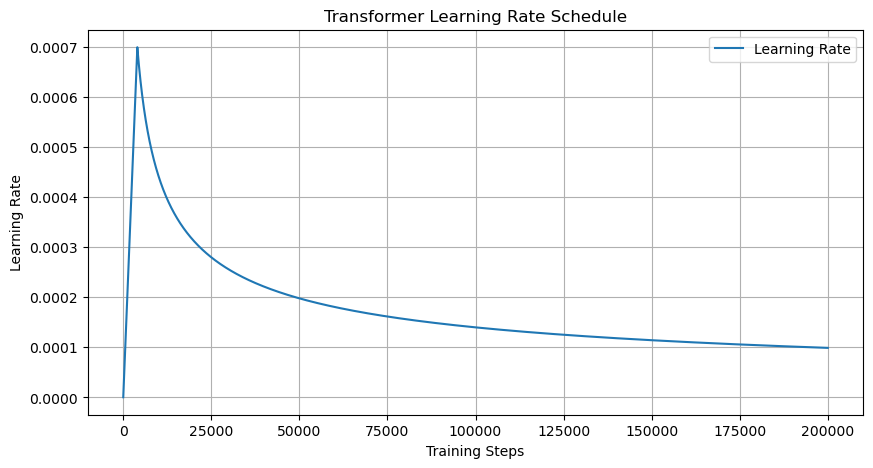

In [42]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    모델 예측과 실제 정답을 비교하여 정확도를 계산합니다.
    
    Args:
        y_pred (Tensor): 모델 출력, shape = (batch_size, seq_len, vocab_size)
        y_true (Tensor): 실제 정답 토큰, shape = (batch_size, seq_len)
        pad_id (int): 패딩 토큰 ID (정답에 포함되어도 정확도 계산에서 제외)
    
    Returns:
        acc (Tensor): 배치 단위 정확도 (0~1)
    """
    # 1) vocab 차원에서 가장 높은 확률을 가진 토큰 선택
    preds = y_pred.argmax(dim=-1)  # shape = (batch_size, seq_len)

    # 2) 패딩이 아닌 위치만 선택
    mask = (y_true != pad_id)      # shape = (batch_size, seq_len)

    # 3) 예측이 정답과 같고, 패딩이 아닌 위치만 True
    correct = (preds == y_true) & mask

    # 4) 정확도 = 맞춘 토큰 수 / 패딩 제외 전체 토큰 수
    acc = correct.float().sum() / mask.float().sum()

    return acc

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [45]:
def train_step(model, batch, optimizer, loss_function, device):
    """
    한 배치(batch)에 대한 학습 단계 수행
    """
    model.train()  
    enc_input, dec_input, target = [x.to(device) for x in batch] 

    optimizer.zero_grad()  # 이전 gradient 초기화

    # 1) 모델 forward pass: (batch_size, seq_len, vocab_size) 출력
    logits = model(enc_input, dec_input)

    # 2) Loss 계산
    # CrossEntropyLoss는 (batch_size, vocab_size, seq_len) 형태 필요
    # pad_id 위치는 loss 계산에서 무시 가능
    loss = loss_function(logits.permute(0, 2, 1), target)

    # 3) Backpropagation
    loss.backward()
    optimizer.step()

    # 4) 정확도 계산 (패딩 토큰 제외)
    acc = accuracy_function(logits, target, pad_id=sp.pad_id())

    return loss.item(), acc


In [46]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    """
    전체 학습 루프
    """
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0

        for step, batch in enumerate(dataloader):
            # 배치 학습 수행
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 100 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트 (step 단위)
            scheduler.step()

        # 에포크 평균 Loss, Accuracy 출력
        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [47]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.0383, Acc: 0.0000
[Epoch 1, Step 100] Loss: 8.9969, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.0644, Acc: 0.0025
[Epoch 1, Step 300] Loss: 9.0081, Acc: 0.0023
[Epoch 1, Step 400] Loss: 8.9794, Acc: 0.0000
[Epoch 1, Step 500] Loss: 9.0225, Acc: 0.0000
[Epoch 1, Step 600] Loss: 8.9746, Acc: 0.0024
[Epoch 1, Step 700] Loss: 8.9713, Acc: 0.0000
[Epoch 1, Step 800] Loss: 8.9830, Acc: 0.0023
[Epoch 1, Step 900] Loss: 8.9258, Acc: 0.0000
[Epoch 1, Step 1000] Loss: 8.9203, Acc: 0.0025
[Epoch 1, Step 1100] Loss: 8.8273, Acc: 0.0216
[Epoch 1, Step 1200] Loss: 8.9272, Acc: 0.0076
[Epoch 1, Step 1300] Loss: 8.8585, Acc: 0.0216
Epoch 1 Completed - Avg Loss: 8.9575, Avg Acc: 0.0047
[Epoch 2, Step 0] Loss: 8.8141, Acc: 0.0218
[Epoch 2, Step 100] Loss: 8.7983, Acc: 0.0188
[Epoch 2, Step 200] Loss: 8.7960, Acc: 0.0340
[Epoch 2, Step 300] Loss: 8.7856, Acc: 0.0277
[Epoch 2, Step 400] Loss: 8.7337, Acc: 0.0363
[Epoch 2, Step 500] Loss: 8.5755, Acc: 0.0560
[Epoch 2, Step 600] Loss: 

# 14. 챗봇 테스트하기

In [48]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    """
    Transformer 디코더를 이용한 시퀀스 생성 (Inference)
    
    Args:
        model: 학습된 Transformer 모델
        sentence: 입력 문장 (string)
        tokenizer: SentencePiece tokenizer
        device: 연산 디바이스 ('cpu' 또는 'cuda')
    
    Returns:
        output_sequence: 생성된 토큰 ID 시퀀스 (list of int)
    """
    # 특수 토큰
    START_TOKEN = tokenizer.bos_id()   # <s> (문장 시작)
    END_TOKEN = tokenizer.eos_id()     # </s> (문장 종료)
    MAX_LENGTH = 40                    # 생성 최대 길이

    # 1) 입력 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 2) 인코더 입력 생성: [START] + 토큰화 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 3) 디코더 입력 초기화: START_TOKEN만 포함
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 평가 모드로 전환 (dropout 등 비활성화)
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for i in range(MAX_LENGTH):
            # 4) 모델 forward
            # enc_input: 인코더 입력
            # dec_input: 지금까지 생성된 디코더 입력
            logits = model(enc_input, dec_input)  # (batch_size=1, seq_len, vocab_size)

            # 5) 마지막 시점의 예측만 사용
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # 6) argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # (1,)

            # 7) 종료 토큰이면 생성 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 8) 디코더 입력에 예측 토큰 추가
            predicted_id = predicted_id.unsqueeze(0)      # (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)  # (1, seq_len+1)

    # 9) 최종 출력 시퀀스: batch 차원 제거
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence


In [49]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    """
    Transformer 모델을 이용해 입력 문장에 대한 응답 문장 생성
    
    Args:
        model: 학습된 Transformer 모델
        sentence: 입력 문장 (string)
        tokenizer: SentencePiece tokenizer
        device: 연산 디바이스 ('cpu' 또는 'cuda')
    
    Returns:
        predicted_sentence: 모델이 생성한 문장 (string)
    """
    # 1) 디코더 인퍼런스를 통해 예측된 토큰 ID 시퀀스 생성
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 2) 토크나이저로 디코딩
    # - START/END 토큰 및 패딩 토큰은 제거
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    # 3) 결과 출력
    print("입력 :", sentence)
    print("출력 :", predicted_sentence)

    return predicted_sentence


In [50]:
sentence = 'Where have you been?'
sentence_generation(model, sentence, sp, device)

입력 : Where have you been?
출력 : i m .


'i m .'

In [51]:
sentence = "It's a trap"
sentence_generation(model, sentence, sp, device)

입력 : It's a trap
출력 : i m .


'i m .'